In [3]:
# Step 1: Clone the repository and install dependencies
# Assuming you haven't already done this, clone the Prithvi foundation repository and install requirements.
!git clone https://github.com/NASA-IMPACT/Prithvi-WxC.git
!cd Prithvi-WxC && pip install -e .[examples]

Cloning into 'Prithvi-WxC'...


Obtaining file:///B:/FloodDataset-20241111T140634Z-001/FloodDataset/Prithvi-WxC
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Building editable for PrithviWxC (pyproject.toml): started
  Building editable for PrithviWxC (pyproject.toml): finished with status 'done'
  Created wheel for PrithviWxC: filename=prithviwxc-1.0.0-py3-none-any.whl size=2088 sha256=c5d535940bebe454afd10dfe8b6210db399b7f6db60fb4134b4e111c6ec23a8d
  Stored in directory: C:\Users\mehdih\AppData\Local\Temp\pip-ephem-wheel-cache-7pry5cuy\wheels\33\f1\53\596f0d1eb363ebd8e7c0

In [4]:
# Clone the fine-tuning repository
!git clone https://github.com/NASA-IMPACT/hls-foundation-os.git
!cd hls-foundation-os && pip install -r requirements.txt

Cloning into 'hls-foundation-os'...
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [31]:


# Step 2: Prepare the Data Pipeline
import os
import json
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random

class FloodDataset(Dataset):
    def __init__(self, images_before, images_after, masks, transform=None):
        self.transform = transform
        self.images_before = images_before
        self.images_after = images_after
        self.masks = masks

    def __len__(self):
        return len(self.images_before)

    def __getitem__(self, idx):
        img_before_path = self.images_before[idx]
        img_after_path = self.images_after[idx]
        mask_path = self.masks[idx]

        img_before = Image.open(img_before_path).convert('L')
        img_after = Image.open(img_after_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        if self.transform:
            img_before = self.transform(img_before)
            img_after = self.transform(img_after)
            mask = self.transform(mask)

        # Stack before and after images together to use as input
        img_pair = torch.cat((img_before, img_after), dim=0)
        return img_pair, mask



In [23]:
import random

In [36]:

# Step 3: Load and Split Your Dataset
from torchvision import transforms

data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load JSON files for all flood scenarios
root_dir = "chips"
folders = ["after", "before", "mask"]
json_paths = {folder: [os.path.join(root_dir, folder, f"flood{i}.json") for i in range(1, 4)] for folder in folders}

images_before = []
images_after = []
masks = []

for i in range(3):
    with open(json_paths['before'][i], 'r') as f:
        before_data = json.load(f)
        images_before.extend([item['image_path'] for item in before_data])
    with open(json_paths['after'][i], 'r') as f:
        after_data = json.load(f)
        images_after.extend([item['image_path'] for item in after_data])
    with open(json_paths['mask'][i], 'r') as f:
        mask_data = json.load(f)
        masks.extend([item['image_path'] for item in mask_data])

# Update paths to ensure they are correct
images_before = [os.path.normpath(path) for path in images_before]
images_after = [os.path.normpath(path) for path in images_after]
masks = [os.path.normpath(path) for path in masks]

# Shuffle and split the data into train, validation, and test sets
data = list(zip(images_before, images_after, masks))
random.shuffle(data)
images_before, images_after, masks = zip(*data)

total_len = len(images_before)
train_split = int(0.7 * total_len)
val_split = int(0.15 * total_len)

train_data = data[:train_split]
val_data = data[train_split:train_split + val_split]
test_data = data[train_split + val_split:]

train_images_before, train_images_after, train_masks = zip(*train_data)
val_images_before, val_images_after, val_masks = zip(*val_data)
test_images_before, test_images_after, test_masks = zip(*test_data)

# Create datasets and loaders
train_dataset = FloodDataset(list(train_images_before), list(train_images_after), list(train_masks), transform=data_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

val_dataset = FloodDataset(list(val_images_before), list(val_images_after), list(val_masks), transform=data_transform)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

test_dataset = FloodDataset(list(test_images_before), list(test_images_after), list(test_masks), transform=data_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [42]:

# Step 4: Define the Model Architecture
import torch.nn as nn
import torchvision.models as models

class PrithviFloodSegmentationModel(nn.Module):
    def __init__(self):
        super(PrithviFloodSegmentationModel, self).__init__()
        # Load Prithvi backbone (assuming pretrained ResNet backbone is available)
        self.backbone = models.resnet18(pretrained=True)
        self.backbone.conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)  # Update input channels to 2
        self.backbone.fc = nn.Identity()  # Remove final classification layer
        
        # Define new decoder head for flood segmentation
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 1, kernel_size=1)  # Output 1 channel for binary segmentation
        )

    def forward(self, x):
        features = self.backbone(x)
        features = features.view(features.size(0), 512, 1, 1)  # Reshape features for decoder with correct channel size
        out = self.decoder(features)
        out = nn.functional.interpolate(out, size=(256, 256), mode='bilinear', align_corners=False)  # Upsample to match mask size
        return out

In [46]:

# Step 5: Train the Model
from tqdm import tqdm

model = PrithviFloodSegmentationModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(total=len(train_loader), desc=f"Epoch [{epoch+1}/{num_epochs}]", unit="batch") as pbar:
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Validation Loss: {val_loss:.4f}")

Epoch [1/5]: 100%|██████████| 806/806 [09:44<00:00,  1.38batch/s, loss=0.00112] 


Epoch [1/5], Loss: 0.0054
Validation Loss: 0.0022


Epoch [2/5]: 100%|██████████| 806/806 [08:46<00:00,  1.53batch/s, loss=0.000894]


Epoch [2/5], Loss: 0.0022
Validation Loss: 0.0022


Epoch [3/5]: 100%|██████████| 806/806 [08:56<00:00,  1.50batch/s, loss=0.00562] 


Epoch [3/5], Loss: 0.0022
Validation Loss: 0.0022


Epoch [4/5]: 100%|██████████| 806/806 [08:11<00:00,  1.64batch/s, loss=0.00189] 


Epoch [4/5], Loss: 0.0022
Validation Loss: 0.0022


Epoch [5/5]: 100%|██████████| 806/806 [09:07<00:00,  1.47batch/s, loss=0.00231] 


Epoch [5/5], Loss: 0.0022
Validation Loss: 0.0022


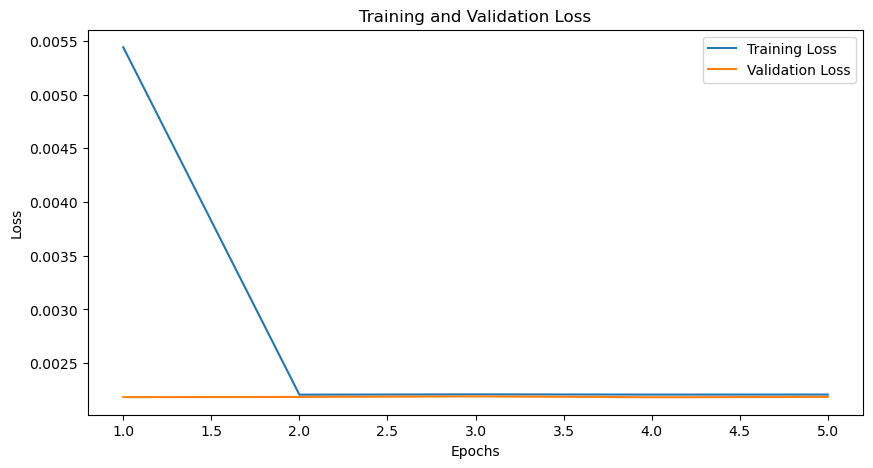

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

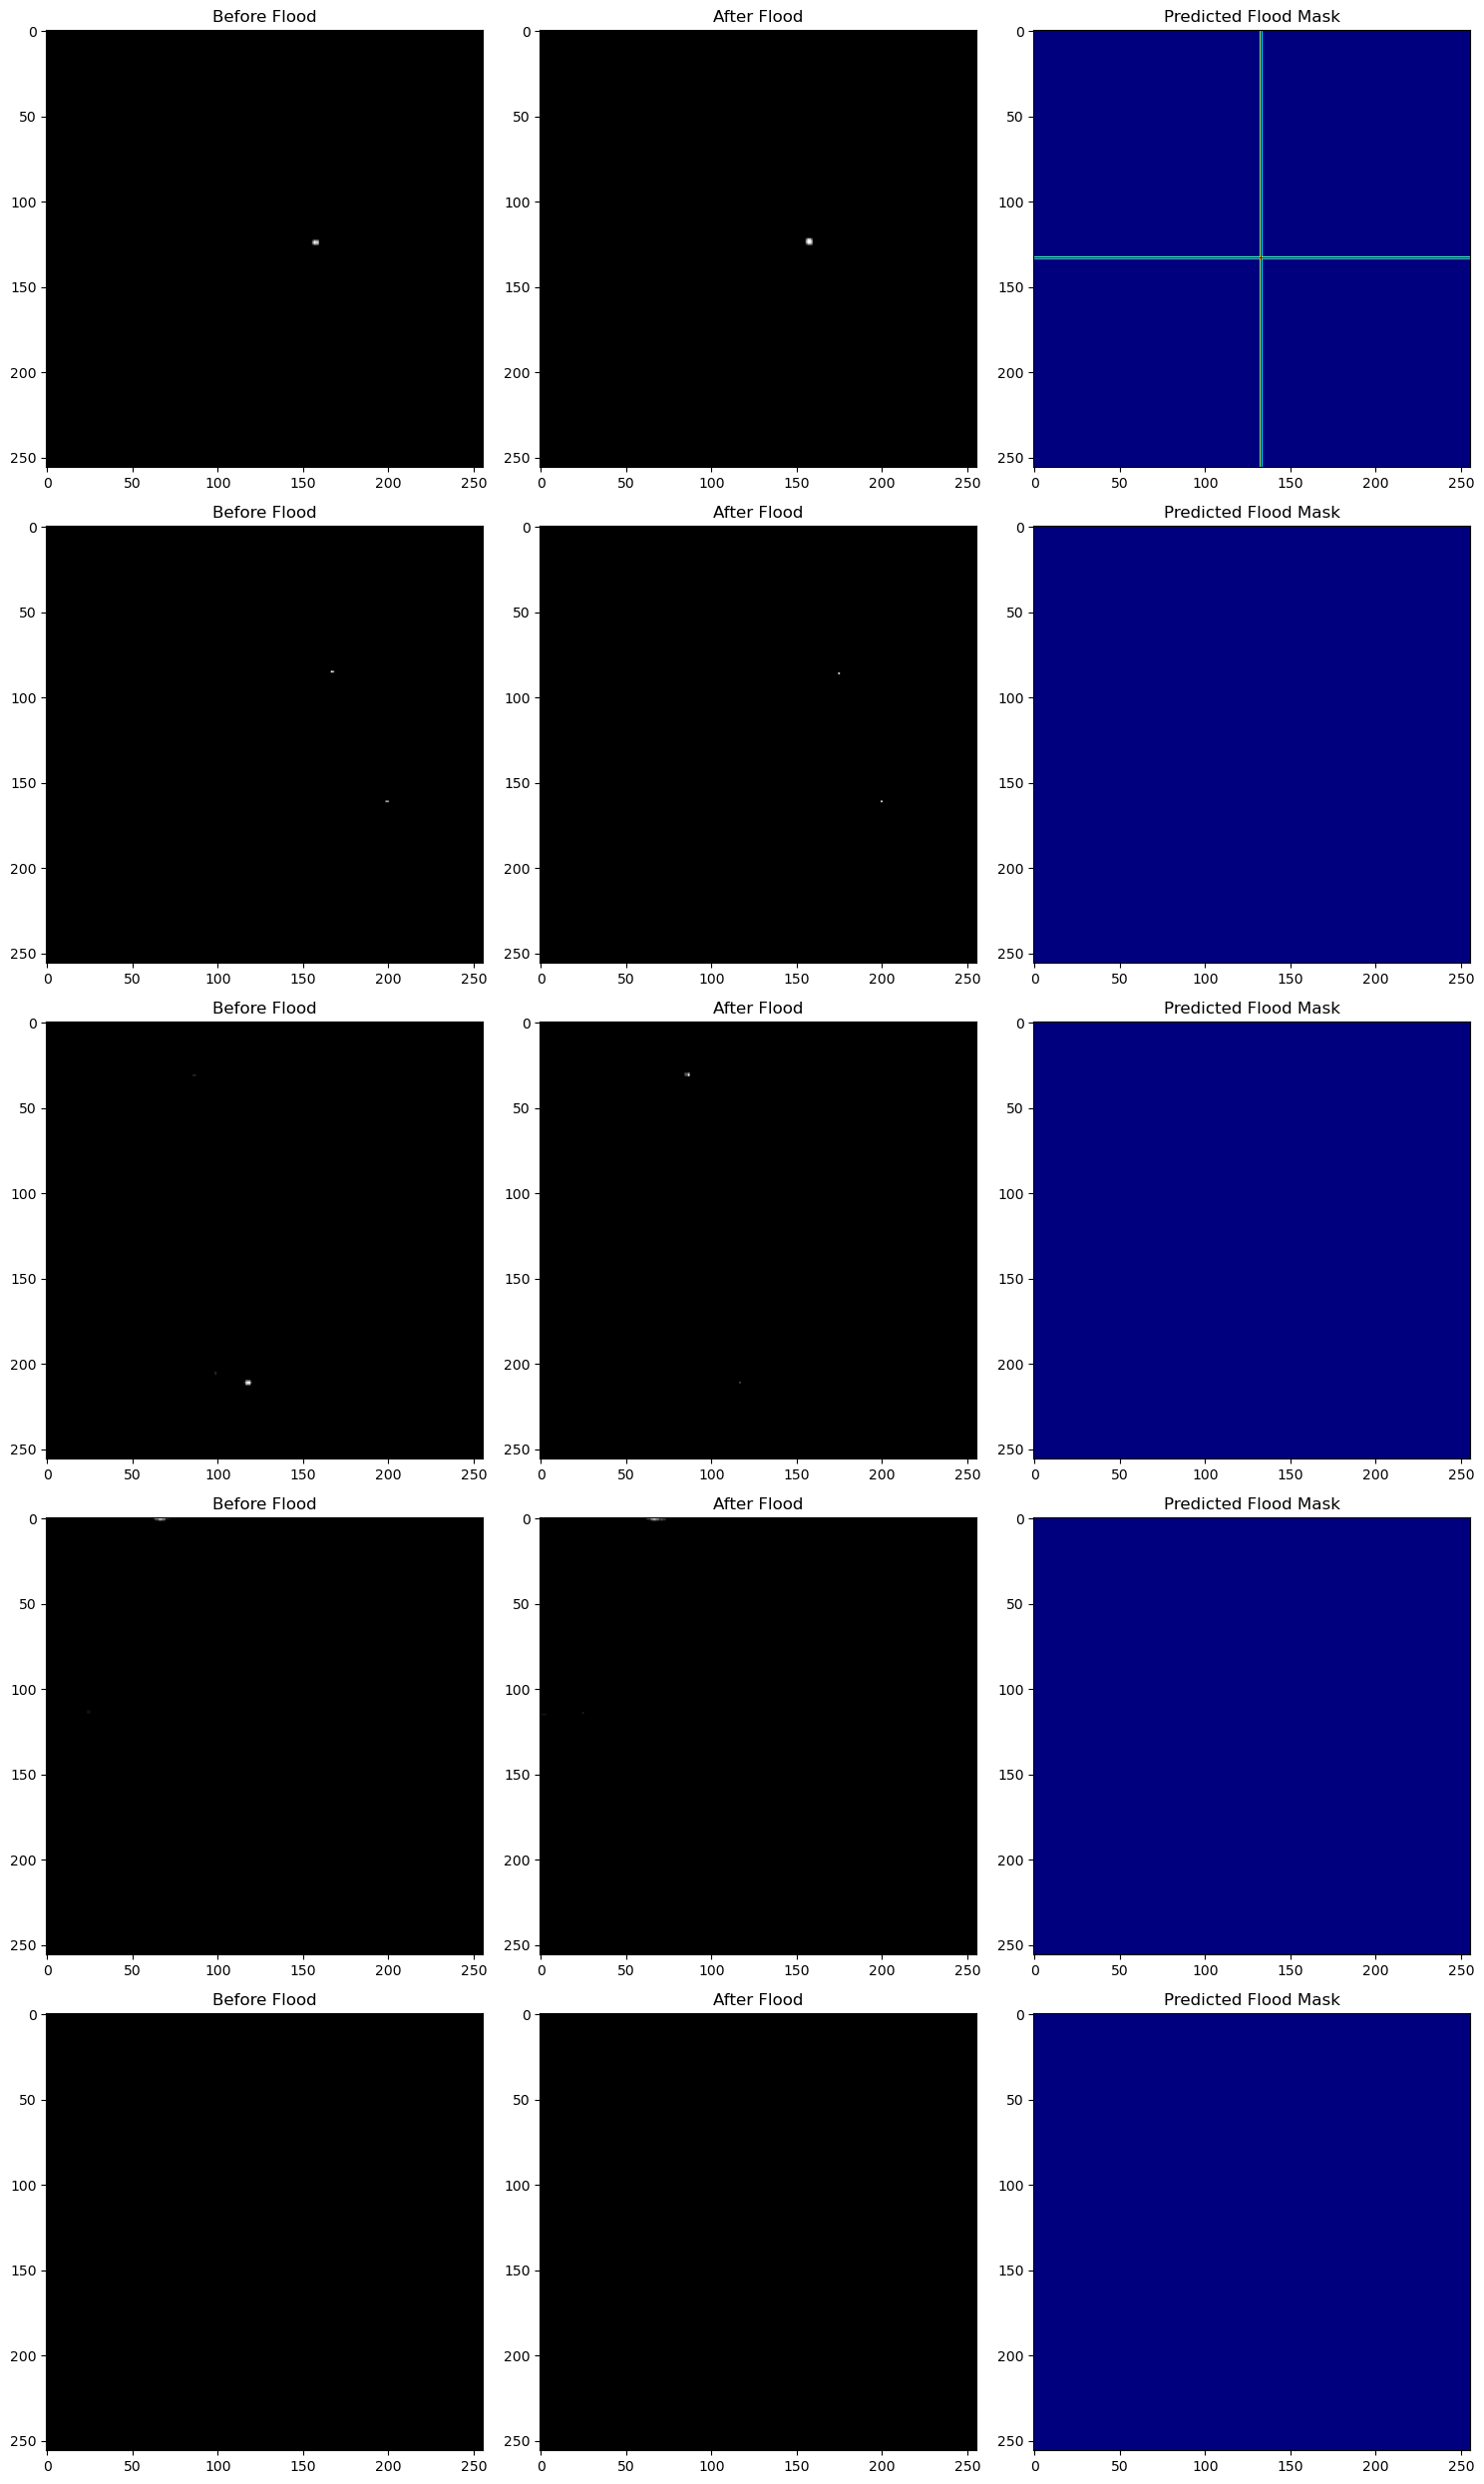

In [51]:

# Step 8: Visualize Model Predictions
model.eval()
import numpy as np

# Visualize a few predictions from the validation set
num_samples = 5
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))

with torch.no_grad():
    for i in range(num_samples):
        img_pair, mask = val_dataset[i]
        img_pair = img_pair.unsqueeze(0).to(device)
        output = model(img_pair)
        output = torch.sigmoid(output).cpu().squeeze().numpy()
        mask = mask.numpy()
        img_before = img_pair[0, 0].cpu().numpy()
        img_after = img_pair[0, 1].cpu().numpy()

        axes[i, 0].imshow(img_before, cmap='gray')
        axes[i, 0].set_title('Before Flood')
        axes[i, 1].imshow(img_after, cmap='gray')
        axes[i, 1].set_title('After Flood')
        axes[i, 2].imshow(output, cmap='jet')
        axes[i, 2].set_title('Predicted Flood Mask')

plt.tight_layout()
plt.show()


In [55]:
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score

In [57]:
# Step 9: Evaluate Model Performance
model.eval()
iou_scores = []
dice_scores = []
precision_scores = []
recall_scores = []

with torch.no_grad():
    for images, masks in val_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs).cpu().numpy()
        masks = masks.cpu().numpy()

        # Flatten outputs and masks for metric calculation
        outputs = (outputs > 0.5).astype(np.uint8).flatten()
        masks = (masks > 0.5).astype(np.uint8).flatten()

        # Check if there are any positive samples in masks or outputs
        if np.sum(masks) == 0 and np.sum(outputs) == 0:
            # Skip metric calculation if both masks and outputs are empty
            continue

        # Calculate metrics
        iou = jaccard_score(masks, outputs, average='binary', zero_division=1)
        dice = f1_score(masks, outputs, average='binary', zero_division=1)
        precision = precision_score(masks, outputs, average='binary', zero_division=1)
        recall = recall_score(masks, outputs, average='binary', zero_division=1)

        iou_scores.append(iou)
        dice_scores.append(dice)
        precision_scores.append(precision)
        recall_scores.append(recall)

# Print average metrics
iou_avg = np.mean(iou_scores) if iou_scores else 0.0
dice_avg = np.mean(dice_scores) if dice_scores else 0.0
precision_avg = np.mean(precision_scores) if precision_scores else 0.0
recall_avg = np.mean(recall_scores) if recall_scores else 0.0

print(f"Average IoU: {iou_avg:.4f}")
print(f"Average Dice Coefficient: {dice_avg:.4f}")
print(f"Average Precision: {precision_avg:.4f}")
print(f"Average Recall: {recall_avg:.4f}")


Average IoU: 0.0000
Average Dice Coefficient: 0.0000
Average Precision: 0.0000
Average Recall: 0.0000
